In [ ]:
!pip install gymnasium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install swig

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install gymnasium[box2d]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 374.4/374.4 kB 5.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp310-cp310-linux_x86_64.whl size=2376096 sha256=49ad6229738f435b0cc227ffee31d0e5a07040308418bb13334cfc0ade9073f4
  Stored in directory: /root/.cache/pip/wheels/db/8f/6a/eaaadf056fba10a98d986f6dce954e6201ba3126926fc5ad9e
Successfully built box2d-py


In [ ]:
import random
import sys
from time import time
from collections import deque, namedtuple
import numpy as np
import pandas as pd
import gym
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

# Parâmetros globais
BUFFER_SIZE = int(1e5)
BATCH_SIZE = 64
GAMMA = 0.99
TAU = 1e-3
LR = 1e-4
UPDATE_EVERY = 4
MAX_EPISODES = 3000
MAX_STEPS = 1000
ENV_SOLVED = 200
PRINT_EVERY = 100
EPS_START = 1.0
EPS_DECAY = 0.999
EPS_MIN = 0.01
EPS_DECAY_RATES = [0.9, 0.99, 0.999, 0.9999]

# Configuração do ambiente
env = gym.make('LunarLander-v2')
env.seed(0)
state_size = env.observation_space.shape[0]
action_size = env.action_space.n
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Definição da Rede Neural
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, 32)
        self.fc2 = nn.Linear(32, 64)
        self.fc3 = nn.Linear(64, action_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Classe para armazenar e amostrar experiências
class ReplayBuffer():
    def __init__(self, buffer_size, batch_size, seed):
        self.batch_size = batch_size
        self.seed = random.seed(seed)
        self.memory = deque(maxlen=buffer_size)
        self.experience = namedtuple("Experience", field_names=["state", "action", "reward", "next_state", "done"])

    def add_experience(self, state, action, reward, next_state, done):
        experience = self.experience(state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.from_numpy(np.vstack(states)).float().to(device),
            torch.from_numpy(np.vstack(actions)).long().to(device),
            torch.from_numpy(np.vstack(rewards)).float().to(device),
            torch.from_numpy(np.vstack(next_states)).float().to(device),
            torch.from_numpy(np.vstack(dones)).float().to(device)
        )

    def __len__(self):
        return len(self.memory)

# Classe do agente DQN
class DQNAgent:
    def __init__(self, state_size, action_size, seed):
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed)
        self.q_network = QNetwork(state_size, action_size, seed).to(device)
        self.fixed_network = QNetwork(state_size, action_size, seed).to(device)
        self.optimizer = optim.Adam(self.q_network.parameters(), lr=LR)
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE, seed)
        self.timestep = 0

    def step(self, state, action, reward, next_state, done):
        self.memory.add_experience(state, action, reward, next_state, done)
        self.timestep += 1
        if self.timestep % UPDATE_EVERY == 0:
            if len(self.memory) > BATCH_SIZE:
                experiences = self.memory.sample()
                self.learn(experiences)

    def learn(self, experiences):
        states, actions, rewards, next_states, dones = experiences
        action_values = self.fixed_network(next_states).detach()
        max_action_values = action_values.max(1)[0].unsqueeze(1)
        Q_target = rewards + (GAMMA * max_action_values * (1 - dones))
        Q_expected = self.q_network(states).gather(1, actions)
        loss = F.mse_loss(Q_expected, Q_target)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        self.update_fixed_network(self.q_network, self.fixed_network)

    def update_fixed_network(self, q_network, fixed_network):
        for source_parameters, target_parameters in zip(q_network.parameters(), fixed_network.parameters()):
            target_parameters.data.copy_(TAU * source_parameters.data + (1.0 - TAU) * target_parameters.data)

    def act(self, state, eps=0.0):
        if random.random() < eps:
            return np.random.randint(self.action_size)
        else:
            state = torch.from_numpy(state).float().unsqueeze(0).to(device)
            self.q_network.eval()
            with torch.no_grad():
                action_values = self.q_network(state)
            self.q_network.train()
            return np.argmax(action_values.cpu().data.numpy())

    def checkpoint(self, filename):
        torch.save(self.q_network.state_dict(), filename)

# Função para treinar o agente DQN
def train_dqn(agent, eps_start=EPS_START, eps_decay=EPS_DECAY, eps_min=EPS_MIN):
    scores = []
    scores_window = deque(maxlen=100)
    eps = eps_start
    for episode in range(1, MAX_EPISODES + 1):
        state = env.reset()
        score = 0
        for t in range(MAX_STEPS):
            action = agent.act(state, eps)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            score += reward
            if done:
                break
            eps = max(eps * eps_decay, eps_min)
        scores_window.append(score)
        scores.append(score)
        mean_score = np.mean(scores_window)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(episode, mean_score), end="")
        if mean_score >= ENV_SOLVED:
            print('\nEnvironment solved in {} episodes!\tAverage Score: {:.2f}'.format(episode - 100, mean_score))
            agent.checkpoint('solved_200.pth')
            break
    return scores


# Treinamento do agente DQN
dqn_agent = DQNAgent(state_size, action_size, seed=0)
start = time()
scores = train_dqn(dqn_agent, eps_start=EPS_START, eps_decay=EPS_DECAY, eps_min=EPS_MIN)
end = time()
print('\nTraining took {:.2f} seconds'.format(end - start))


Episode 1909	Average Score: 39.80

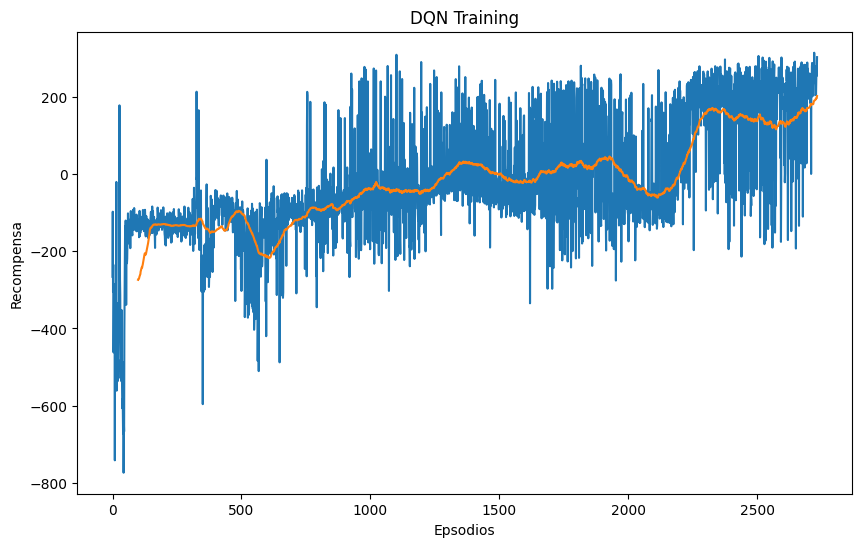

In [ ]:
# Plotagem dos resultados
plt.figure(figsize=(10, 6))
plt.plot(scores)
plt.plot(pd.Series(scores).rolling(100).mean())
plt.title('DQN Training')
plt.xlabel('Epsodios')
plt.ylabel('Recompensa')
plt.show()
